In [1]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from scipy.signal import find_peaks
from scipy import signal
from scipy.integrate import trapz
from scipy.interpolate import interp1d
import seaborn as sns
import heartpy as hp
import os
import pickle
import warnings
warnings.simplefilter('ignore', np.RankWarning)

In [2]:
def plt_performance(history, path='./', filename=''):
    epoch = list(range(0,len(history.history['loss'])))
    
    fig, (his_accuracy, his_loss) = plt.subplots(nrows=2,ncols=1,figsize=(10,8),sharex=True)
    his_loss.plot(epoch, history.history['loss'], label='Training loss')
    his_loss.plot(epoch, history.history['val_loss'], label='Validation loss')
    his_loss.set_xlabel("Epochs", fontsize=14)
    his_loss.set_ylabel("Loss", fontsize=14)
    his_loss.set_title("Loss", fontsize=14)
    his_loss.legend(loc='best')
    
    his_accuracy.plot(epoch, history.history['acc'], label='Training accuracy')
    his_accuracy.plot(epoch, history.history['val_acc'], label='Validation accuracy')
    his_accuracy.set_xlabel("Epochs", fontsize=14)
    his_accuracy.set_ylabel("Accuracy", fontsize=14)
    his_accuracy.set_title("Accuracy", fontsize=14)
    his_accuracy.legend(loc='best')
    
    fig.tight_layout()
    if filename == '':
        plt.savefig(f'{path}/performance.png', bbox_inches='tight')
    else:
        plt.savefig(f'{path}/{filename}.png', bbox_inches='tight')
        
"""
Pre-processing method
"""

def preprocessing(PPG_data):
    """
    Fast Emotion Recognition reference
    """

    index = 0
    x = list(range(0,len(PPG_data[0])))
    
    for PPG in PPG_data:
        poly = np.polyfit(x, PPG, deg=50)
        polied = np.polyval(poly, x)
        detrended = PPG - polied
        PPG_data[index] = detrended
        index += 1
        
    return PPG_data


# def preprocessing(ppg_data, view = False, participant = ''):
#     """
#     Analysis PPG signal reference
#     """
    
#     # moving average function
#     m_avg = lambda t, x, w : (np.asarray([t[i] for i in range(w, len(x) - w)]),
#                           np.convolve(x, np.ones((2*w + 1, )) / (2*w + 1),
#                                       mode = 'valid'))

#     fs = len(ppg_data)/(60)  # sample rate

#     # moving average
#     w_size = int(fs*.5)  # width of moving window
#     times = list(range(0,len(ppg_data)))
#     mt, ms = m_avg(times, ppg_data, w_size)

#     sign = (ppg_data[w_size:-w_size]-ms)

#     analytical_signal = np.abs(signal.hilbert(sign))

#     fs = len(sign) / (max(mt) - min(mt))
#     w_size = int(fs)
#     mt_new, mov_avg = m_avg(mt, analytical_signal, w_size)

#     signal_pure = sign[w_size : -w_size] / mov_avg
    
#     if view:
#         plt.ioff()
        
#         fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (10, 8), sharex=True)
#         ax1.plot(times, ppg_data, "b-", label="Original")
#         ax1.legend(loc='best')
#         ax1.set_title("participants"+str(participant)+" Raw", fontsize=14)#, fontweight="bold")

#         ax2.plot(mt, sign, 'r-', label="Pure signal")
#         ax2.plot(mt_new, mov_avg, 'b-', label='Modulation', alpha=.5)
#         ax2.legend(loc='best')
#         ax2.set_title("Raw -> filtered", fontsize=14)#, fontweight="bold")

#         ax3.plot(mt_new, signal_pure, "g-", label="Demodulated")
#         ax3.set_xlim(0, mt[-1])
#         ax3.set_title("Raw -> filtered -> demodulated", fontsize=14)#, fontweight="bold")

#         ax3.set_xlabel("Time (sec)", fontsize=14) # common axis label
#         ax3.legend(loc='best')

#         fig.tight_layout()
#         plt.savefig(f'./plot_img/{participant}.png', bbox_inches='tight')
        
#     return signal_pure

    
def get_peaks(ppg_processed):
    diff_sig_2 = np.diff(ppg_processed) ## do
    peaks_2, _ = find_peaks(diff_sig_2, distance=100*(30/60), prominence=0.01)
    result = []
    peaks = []
    
    for i in range(len(peaks_2)):
        if diff_sig_2[peaks_2][i] > 40:
            result.append(peaks_2[i])
            peaks.append(diff_sig_2[peaks_2][i])
            
    return result, peaks, diff_sig_2

In [3]:
dir_list_ = os.listdir("./data")
dir_list_.sort()
count = 0
dir_list = []
for i in range(22):
    dir_list.append(dir_list_[i])
    
#### pop unavailable data
dir_list.pop(5)
dir_list.pop(2)

print(dir_list)
df_PPG = pd.DataFrame(columns=['participant','video_number','ppg','valence','arousal'])
Valence_data = []
Arousal_data = []
PPG_data = []

file_num = 0
for file in dir_list:
    dat_file = f'./data/{file}'
    with open(dat_file, 'rb') as f:
        Channel_data = pickle.load(f,encoding='latin1')
    data = Channel_data["data"]
    labels = Channel_data["labels"]
    for video_num in range(40):
        dataP = data[video_num,38]
        dataP = dataP[384:]
        
        label = labels[video_num]
        if label[0] < 5:
            Valence = 0
        if label[0] >= 5:
            Valence = 1
        if label[1] < 5:
            Arousal = 0
        if label[1] >= 5:
            Arousal = 1
        instance = [(file_num, video_num, dataP, Valence, Arousal)]
        new_instance = pd.DataFrame(instance, columns=['participant','video_number','ppg','valence','arousal'])
        df_PPG = pd.concat([df_PPG, new_instance], ignore_index = True)
        PPG_data.append(dataP)
        Valence_data.append(Valence)
        Arousal_data.append(Arousal)
    file_num += 1
    
PPG_shape = np.array(PPG_data)
PPG_shape.shape

['s01.dat', 's02.dat', 's04.dat', 's05.dat', 's07.dat', 's08.dat', 's09.dat', 's10.dat', 's11.dat', 's12.dat', 's13.dat', 's14.dat', 's15.dat', 's16.dat', 's17.dat', 's18.dat', 's19.dat', 's20.dat', 's21.dat', 's22.dat']


(800, 7680)

In [4]:
PPG_data = df_PPG['ppg']

preprocessed = preprocessing(PPG_data)

/home/sselab/anaconda3/envs/EmotionRecognition/lib/python3.8/site-packages/numpy/lib/polynomial.py:627: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/home/sselab/anaconda3/envs/EmotionRecognition/lib/python3.8/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [5]:
# Concatenate PPG data of each person to use min-max normalization method 
i = 1
new_PPG = []
tmp_PPG = np.empty(0)
for PPG in preprocessed:
    if i % 40 != 0:
        tmp_PPG = np.concatenate([tmp_PPG, PPG])
    else:
        tmp_PPG = np.concatenate([tmp_PPG, PPG])
        new_PPG.append(tmp_PPG)
        tmp_PPG = np.empty(0)
    i += 1
    
    
# Normalize personal PPG data and Split into per video
new_PPG = np.array(new_PPG)
new_PPG.shape[0]
new_PPG = new_PPG.reshape(new_PPG.shape[0],new_PPG.shape[1],1)

normalized = []

for PPG in new_PPG:
    # Normalized personal PPG
    scaler = MinMaxScaler()
    # norm = scaler.fit_transform(PPG) * 1000
    norm = scaler.fit_transform(PPG)
    
    # Split into per video
    for i in range(40):
        norm_video = norm[i*7680 : i*7680+7680]
        normalized.append(norm_video)

normalized = np.array(normalized)
normalized.shape

(800, 7680, 1)

In [6]:
timestep = 1280
segmented = []
valence_data = []
arousal_data = []

################################################
# for index in range(len(preprocessed) - timestep): 
#     segmented.append(preprocessed[index: index + timestep])
idx = 0
for PPG in normalized:
    for index in range(0, len(PPG) - timestep, 128):
        segmented.append(PPG[index : index + timestep,:])
    valence_data.append(Valence_data[idx])
    idx += 1
print(len(segmented))

40000


In [7]:
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)
from tensorflow import keras
from tensorflow.keras import layers, callbacks
# from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, GRU

In [8]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 2 GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)]) # limit in megabytes
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [9]:
train_x = segmented
train_valence = valence_data
train_arousal = arousal_data

In [10]:
x_train_data = np.array(train_x).astype(np.float32)
y_train_data = np.array(train_valence).astype(np.float32)

X_train = x_train_data.reshape((x_train_data.shape[0], x_train_data.shape[1],1))
Y_train = y_train_data.reshape((y_train_data.shape[0],1))

print(f"X_train shape : {X_train.shape}, Y_train shape : {Y_train.shape}")

X_train shape : (40000, 1280, 1), Y_train shape : (800, 1)


In [11]:
# Set Hyperparameters of the model
learning_rate = 0.00001
epochs = 10
batch_size=256

In [12]:
# from tensorflow.keras.layers import LSTM, GRU


# one GRU layers with three dense layers-> IT WORKS !
model2 = Sequential()
model2.add(GRU(units=128,
              dropout=0.3,
              # recurrent_dropout=0.25,
              return_sequences=False,
              input_shape=(1280,1)))
model2.add(BatchNormalization())

# Dense net
model2.add(Dense(512, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))
model2.add(Dense(256, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(1, activation='sigmoid'))

callback_list = [tf.keras.callbacks.ModelCheckpoint(filepath='BinaryClassification_Dense3-callback.h5', monitor='val_accuracy', save_best_only=True),
                tf.keras.callbacks.EarlyStopping(patience=10)]

model2.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=['acc'])
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 128)               50304     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense (Dense)                (None, 512)               66048     
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1

In [13]:
history2=model2.fit(X_train,
                  Y_train,
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_split=0.2,
                  callbacks=callback_list,
                  # shuffle=True,
                  verbose=1)

Epoch 1/10
125/125 [==============================] - 10s 78ms/step - loss: 0.9353 - acc: 0.4793 - val_loss: 0.7070 - val_acc: 0.0000e+00
Epoch 2/10
125/125 [==============================] - 10s 81ms/step - loss: 0.4778 - acc: 0.7782 - val_loss: 0.4239 - val_acc: 1.0000
Epoch 3/10
125/125 [==============================] - 11s 86ms/step - loss: 0.2864 - acc: 0.9067 - val_loss: 0.1764 - val_acc: 1.0000
Epoch 4/10
125/125 [==============================] - 11s 87ms/step - loss: 0.2044 - acc: 0.9493 - val_loss: 0.0735 - val_acc: 1.0000
Epoch 5/10
125/125 [==============================] - 11s 88ms/step - loss: 0.1629 - acc: 0.9643 - val_loss: 0.0379 - val_acc: 1.0000
Epoch 6/10
125/125 [==============================] - 11s 89ms/step - loss: 0.1365 - acc: 0.9729 - val_loss: 0.0220 - val_acc: 1.0000
Epoch 7/10
125/125 [==============================] - 12s 92ms/step - loss: 0.1238 - acc: 0.9766 - val_loss: 0.0159 - val_acc: 1.0000
Epoch 8/10
125/125 [==============================] - 12s 

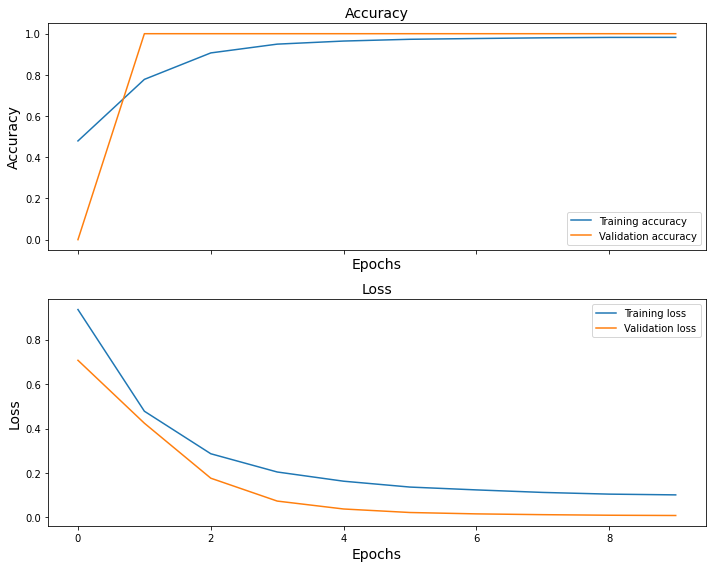

In [14]:
plt_performance(history2,path='./plot_performance',filename='GRU_0527(2)')